# Cross-Lingual Semantic Textual Similarity

در این نوت‌بوک، یک پیاده‌سازی عملی از مسئله‌ی
**شباهت معنایی متون بین زبانی (CL-STS)** ارائه می‌شود.

هدف این دمو، محاسبه‌ی شباهت معنایی بین جملات فارسی و انگلیسی
بدون استفاده از ترجمه ماشینی و با تکیه بر مدل‌های ترنسفورمری چندزبانه است.

در این دمو موارد زیر نمایش داده می‌شود:
- اجرای یک مدل به‌عنوان baseline
- ترکیب چند مدل به‌صورت ensemble
- تحلیل اثر کاهش بُعد با PCA
- بررسی یک مثال واقعی به‌صورت کیفی

دیتاست مورد استفاده:
PESTS (Persian–English STS Dataset)  
https://github.com/mohammadabdous/PESTS


در این بخش، کتابخانه‌های مورد نیاز بارگذاری شده‌اند:

- `sentence-transformers` برای استخراج embedding جملات
- `scikit-learn` برای محاسبه‌ی شباهت کسینوسی و PCA
- `scipy` برای محاسبه‌ی ضریب همبستگی پیرسون
- `matplotlib` برای رسم نمودارهای تحلیلی


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, paired_cosine_distances
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

در این پروژه از سه مدل چندزبانه‌ی مختلف استفاده شده است:

- **XLM-R-based model** برای پوشش قوی زبان‌های مختلف
- **MPNet multilingual** برای نمایش دقیق‌تر روابط معنایی
- **MiniLM multilingual** به‌عنوان مدلی سبک‌تر و سریع‌تر

استفاده از چند مدل به ما اجازه می‌دهد
اطلاعات معنایی متنوع‌تری را در قالب ensemble ترکیب کنیم.


In [ ]:
MODEL_NAMES = [
    "paraphrase-xlm-r-multilingual-v1",
    "paraphrase-multilingual-mpnet-base-v2",
    "paraphrase-multilingual-MiniLM-L12-v2"
]
models = [SentenceTransformer(name) for name in MODEL_NAMES]

df = pd.read_csv("/content/FaEnDataSetV7.csv")

df = df.dropna(subset=['farsiSentence', 'englishSentence', 'score'])
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df = df.dropna(subset=['score'])

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: sentence-transformers/paraphrase-xlm-r-multilingual-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## 1. اجرای مدل پایه (Baseline)

در این مرحله، تنها از یک مدل چندزبانه استفاده می‌کنیم
تا عملکرد پایه‌ی سیستم برای CL-STS مشخص شود.


In [ ]:
model = models[0]
print("Encoding sentences in bulk...")
e1 = model.encode(df["farsiSentence"].tolist(), show_progress_bar=True)
e2 = model.encode(df["englishSentence"].tolist(), show_progress_bar=True)

# 2. Calculate similarities for all rows at once
scores = 1 - paired_cosine_distances(e1, e2)

# 3. Calculate and print correlation
corr, _ = pearsonr(scores, df["score"])
# print(f"\nPearson Correlation: {corr:.4f}")print(f"\nPearson Correlation: {corr:.4f}")scores = []
# for _, row in df.iterrows():
#     e1 = model.encode(row["farsiSentence"], convert_to_numpy=True)
#     e2 = model.encode(row["englishSentence"], convert_to_numpy=True)
#     scores.append(cosine_similarity(e1.reshape(1,-1), e2.reshape(1,-1))[0][0])

pearsonr(scores, df["score"])[0]


Encoding sentences in bulk...


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

KeyboardInterrupt: 

در این روش:
- هر مدل embedding مستقل تولید می‌کند
- embeddingها به‌صورت افقی به هم متصل می‌شوند
- بردار نهایی اطلاعات معنایی همه‌ی مدل‌ها را در خود دارد

عیب این روش، افزایش شدید بُعد بردارهاست
که در ادامه با PCA مدیریت می‌شود.


In [ ]:
def get_ensemble_embeddings(df, models):
    all_emb1 = []
    all_emb2 = []

    for i, m in enumerate(models):
        # Changed this line to avoid the AttributeError
        print(f"Encoding with Model {i+1}: {MODEL_NAMES[i]}")

        e1 = m.encode(df["farsiSentence"].tolist(), show_progress_bar=True)
        e2 = m.encode(df["englishSentence"].tolist(), show_progress_bar=True)
        all_emb1.append(e1)
        all_emb2.append(e2)

    # Concatenate embeddings horizontally (axis=1)
    combined_e1 = np.concatenate(all_emb1, axis=1)
    combined_e2 = np.concatenate(all_emb2, axis=1)
    return combined_e1, combined_e2

# --- CLEANED MAIN EXECUTION ---

# 1. Single Model Baseline
model = models[0]
print("Encoding sentences for baseline...")
e1 = model.encode(df["farsiSentence"].tolist(), show_progress_bar=True)
e2 = model.encode(df["englishSentence"].tolist(), show_progress_bar=True)

scores_baseline = 1 - paired_cosine_distances(e1, e2)
corr_baseline, _ = pearsonr(scores_baseline, df["score"])
print(f"Single Model Correlation: {corr_baseline:.4f}")



## 3. کاهش بُعد با PCA و تحلیل عملکرد

برای بررسی اثر بُعد بردارها بر عملکرد،
از PCA با ابعاد مختلف استفاده می‌کنیم.


Encoding with Model 1: paraphrase-xlm-r-multilingual-v1


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Encoding with Model 2: paraphrase-multilingual-mpnet-base-v2


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Encoding with Model 3: paraphrase-multilingual-MiniLM-L12-v2


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Batches:   0%|          | 0/168 [00:00<?, ?it/s]

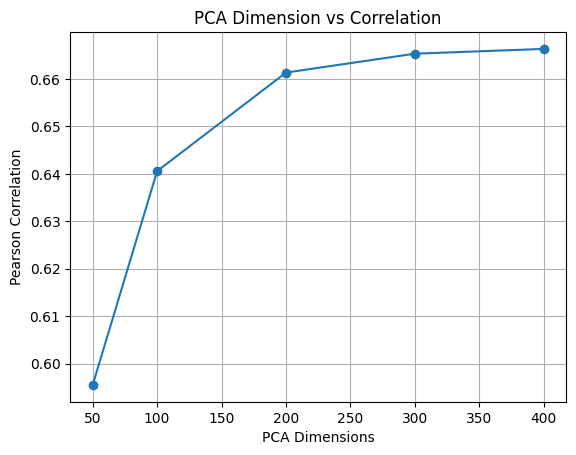

In [ ]:
emb1_large, emb2_large = get_ensemble_embeddings(df, models)

# 3. PCA Analysis
PCA_DIMS = [50, 100, 200, 300, 400]
results = []

for dim in PCA_DIMS:
    pca = PCA(n_components=dim)
    e1_pca = pca.fit_transform(emb1_large)
    e2_pca = pca.transform(emb2_large)

    sims = 1 - paired_cosine_distances(e1_pca, e2_pca)
    res, _ = pearsonr(sims, df["score"])
    results.append(res)

# Plotting the results

plt.plot(PCA_DIMS, results, marker='o')
plt.xlabel("PCA Dimensions")
plt.ylabel("Pearson Correlation")
plt.title("PCA Dimension vs Correlation")
plt.grid(True)
plt.show()

نمودار نشان می‌دهد که:
- با افزایش ابعاد PCA، عملکرد بهبود پیدا می‌کند
- پس از حدود ۲۰۰ تا ۳۰۰ بعد، به حالت اشباع می‌رسد
- می‌توان با بُعد کمتر، عملکردی نزدیک به حالت کامل داشت


## 4. مثال کیفی (Qualitative Evaluation)

در پایان، یک مثال ساده برای بررسی عملکرد عملی سیستم ارائه می‌شود.


In [ ]:
s1 = "این یک جمله آزمایشی است"
s2 = "This is a test sentence"

sims = []
for m in models:
    e1 = m.encode(s1, convert_to_numpy=True)
    e2 = m.encode(s2, convert_to_numpy=True)
    sims.append(cosine_similarity(e1.reshape(1,-1), e2.reshape(1,-1))[0][0])

print("Ensemble similarity:", np.mean(sims))


Ensemble similarity: 0.84284955
Ensemble similarity: 0.84284955
Ensemble similarity: 0.84284955
